# Look at data

In [1]:
import yaml
import os

from IPython.display import display, Image as PImage
import matplotlib.pyplot as plt

In [2]:
import yaml

yaml_file_path = 'D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\data.yaml'

with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)

print(data)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 6, 'names': ['Boredom', 'Confusion', 'Engaged', 'Frustration', 'Sleepy', 'Yawning'], 'roboflow': {'workspace': 'malaviya-national-institute-of-technology-jaipur-india-6e6jq', 'project': 'affective-states', 'version': 2, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/malaviya-national-institute-of-technology-jaipur-india-6e6jq/affective-states/dataset/2'}}


Class: Sleepy


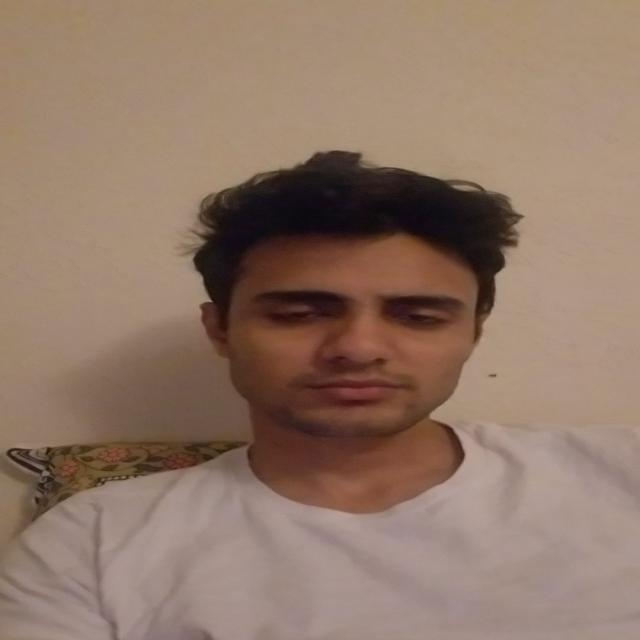

In [3]:
with open("D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\\train\labels\img_000000_jpg.rf.cb2879e21a47ed940992cf73f8e6d335.txt") as file:
    lines = file.readlines()[0]
    c = data["names"][int(lines.split(" ")[0])]
    print(f"Class: {c}")
    
display(PImage("D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\\train\images\img_000000_jpg.rf.cb2879e21a47ed940992cf73f8e6d335.jpg"))

In [4]:
def plot_distribution_classes(path: str, type: str):
    classes = {name: 0 for name in data["names"]}
    for root, dirs, files in os.walk(path):
        for file in files:
            if file[-3:] == "txt":
                full_label_path = path + "\labels\\" + file
                with open(full_label_path) as file:
                    lines = file.readlines()[0]   
                    c = data["names"][int(lines.split(" ")[0])]
                    classes[c] += 1
                file.close()
    
    keys = list(classes.keys())
    values = list(classes.values())
    
    plt.bar(keys, values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Class Counts {type}')
    plt.show()

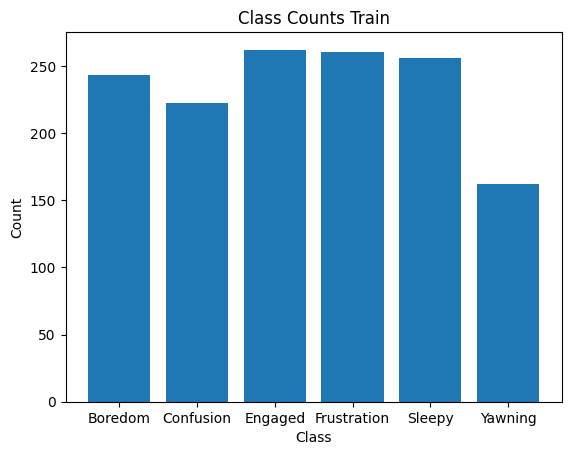

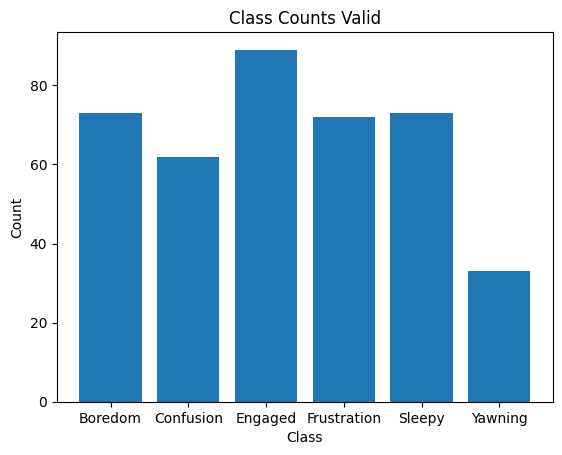

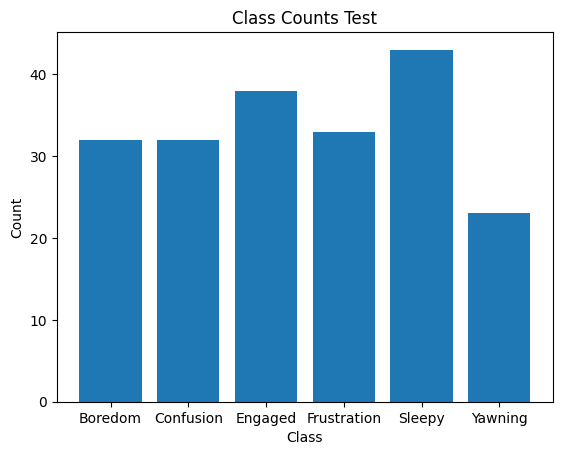

In [5]:
base_path = "D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\\"
plot_distribution_classes(base_path + "train", "Train")
plot_distribution_classes(base_path + "valid", "Valid")
plot_distribution_classes(base_path + "test", "Test")

# Load data

In [6]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image as PILImage
import os
import numpy as np
import random
import torch
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folder = "images"
        self.label_folder = "labels"
        self.image_path = os.path.join(root_dir, self.image_folder)
        self.label_path = os.path.join(root_dir, self.label_folder)
        self.image_list = os.listdir(self.image_path)
        self.label_list = os.listdir(self.label_path)
        
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_path, self.image_list[idx])
        label_name = os.path.join(self.label_path, self.label_list[idx])
        
        image = PILImage.open(img_name).convert("RGB")

        with open(label_name, "r") as f:
            label = int(f.readline().split(" ")[0])

        if self.transform:
            image = self.transform(image)
        return image, label


In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Example transforms, adjust as needed
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(root_dir="D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\\train", transform=transform)
val_dataset = CustomDataset(root_dir="D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\\valid", transform=transform)
test_dataset = CustomDataset(root_dir="D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=np.random.seed(seed))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Amount of train pictures: {len(train_dataset)}")
print(f"Amount of validation pictures: {len(val_dataset)}")
print(f"Amount of test pictures: {len(test_dataset)}")

Amount of train pictures: 1405
Amount of validation pictures: 402
Amount of test pictures: 201


# Define model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

# Define a simple neural network
class SimpleCNNPixels(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNNPixels, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p = 0.2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 56 //2 * 56 //2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.fc3 = nn.Linear(32 * 56 //2 * 56 //2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
num_classes = len(data["names"])
model = SimpleCNNPixels(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dummy_input = torch.randn(64, 3, 224, 224)  
summary(model, dummy_input.size()[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
          Flatten-13                [-1, 25088]               0
           Linear-14                  [

# Training

Epoch 1/50:   0%|          | 0/22 [00:00<?, ?batch/s]

Epoch 50/50: 100%|██████████| 22/22 [01:09<00:00,  3.15s/batch, Loss=0.0298]


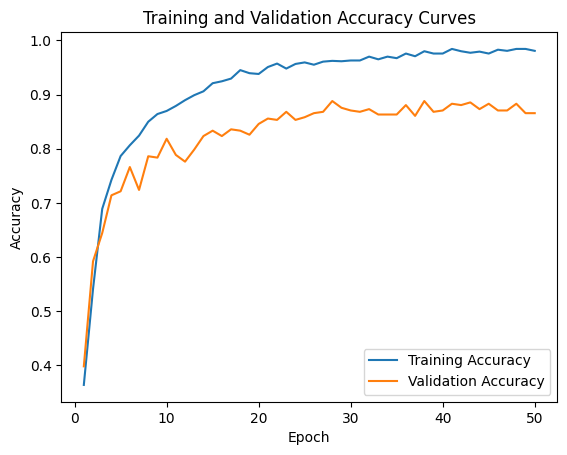

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the number of epochs
num_epochs = 50

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

# Training loop with tqdm progress bar
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Initialize the progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            # Forward pass
            # print(images[0][0].type())
            outputs = model(images)
            # print(labels.type())
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix({'Loss': loss.item()})

            # Calculate training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        # Calculate and store training accuracy
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_outputs = model(val_images)
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        # Calculate validation accuracy
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

# Plotting the training and validation accuracy curves
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

In [14]:
print(train_accuracies[-1])
print(val_accuracies[-1])

0.9807829181494662
0.8656716417910447


In [ ]:
models_path = "D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\models\\"
torch.save(model.state_dict(), models_path + "initial3_10.pth")

# Validation files

In [15]:
model.eval()

def predict_and_show_pic(path: str, file_factor: int, show_output=False):
    index = 0
    amount_of_files = 0
    correct_files = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if index % file_factor == 0:
                if file[-3:] == "txt":
                    full_label_path = path + "\labels\\" + file
                    with open(full_label_path) as labelFile:
                        lines = labelFile.readlines()[0]   
                        original_class = data["names"][int(lines.split(" ")[0])]
                    labelFile.close()
    
                    full_image_path = path + "\images\\" + file[:-3] + "jpg"
                    
                    image = PILImage.open(full_image_path).convert("RGB")
                    input_image = transform(image).unsqueeze(0)
                    val_outputs = model(input_image)
                    _, predicted = torch.max(val_outputs.data, 1)
                    predicted_class = data["names"][int(predicted)]
                    if show_output:
                        display(PImage(full_image_path))
                        print(f"{original_class} -> {predicted_class}")
                    if original_class == predicted_class:
                        correct_files += 1
                    amount_of_files += 1
            index += 1
    print(f"Percentage of correct files: {correct_files / amount_of_files}")

In [16]:
predict_and_show_pic("D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\\valid\\", 1, show_output=False)

Percentage of correct files: 0.8656716417910447


# Test files

In [17]:
predict_and_show_pic("D:\Documents\\Uniefwerk\\5de_jaar\Thesis\Datasets\AffectiveStates\\test\\", 1, show_output=False)

Percentage of correct files: 0.8855721393034826


# Confusion matrix

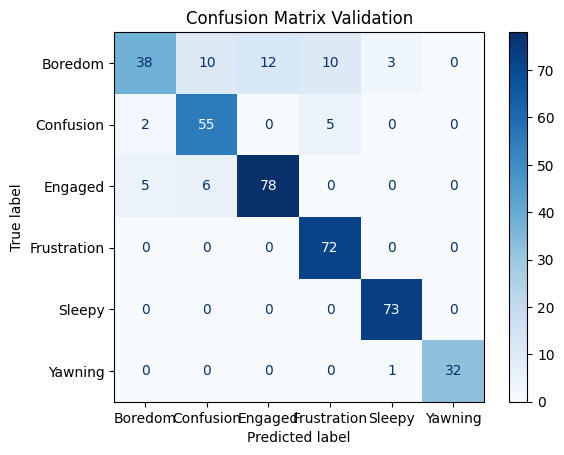

In [19]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have a DataLoader named validation_loader and a trained model
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predictions.numpy())

cm = confusion_matrix(all_labels, all_predictions)
class_names = [str(i) for i in data["names"]]  # Replace with actual class names or labels

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")

plt.title("Confusion Matrix Validation")
plt.show()

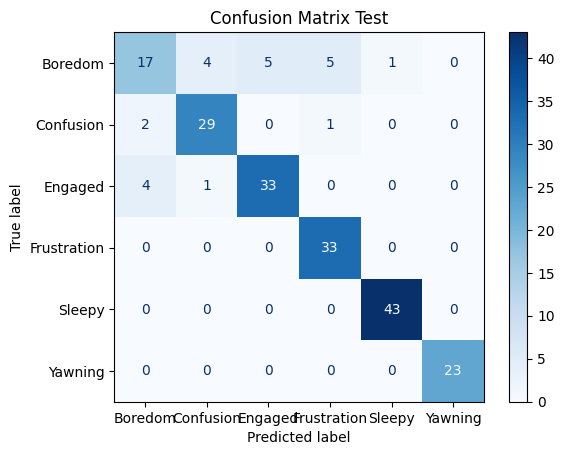

In [20]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have a DataLoader named validation_loader and a trained model
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predictions.numpy())

cm = confusion_matrix(all_labels, all_predictions)
class_names = [str(i) for i in data["names"]]  # Replace with actual class names or labels

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")

plt.title("Confusion Matrix Test")
plt.show()